# TRABALHO 5: Corners e Rastreamento

### Aluno: Kawan Oliveira

## 1. Implemente uma função para detectar pontos Harris em uma imagem. Opcionalmente, você pode utilizar a função da OpenCV, mas a sua solução irá contar menos pontos.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detectar_pontos_harris_sem_opencv(imagem_path, k=0.04, tamanho_vizinhança=3, limiar=0.01):
    # Carregar a imagem em escala de cinza
    imagem = cv2.imread(imagem_path, cv2.IMREAD_GRAYSCALE)

    if imagem is None:
        print("Erro ao carregar a imagem.")
        return None

    # Calcular os gradientes em x e y usando Sobel
    grad_x = cv2.Sobel(imagem, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(imagem, cv2.CV_64F, 0, 1, ksize=3)

    # Calcular os produtos dos gradientes
    Ixx = grad_x ** 2
    Ixy = grad_x * grad_y
    Iyy = grad_y ** 2

    # Aplicar suavização (convolução com uma janela) para calcular as somas ponderadas
    Sxx = cv2.GaussianBlur(Ixx, (tamanho_vizinhança, tamanho_vizinhança), 0)
    Sxy = cv2.GaussianBlur(Ixy, (tamanho_vizinhança, tamanho_vizinhança), 0)
    Syy = cv2.GaussianBlur(Iyy, (tamanho_vizinhança, tamanho_vizinhança), 0)

    # Calcular a resposta de Harris para cada pixel
    det_M = (Sxx * Syy) - (Sxy ** 2)
    trace_M = Sxx + Syy
    R = det_M - k * (trace_M ** 2)  # Fórmula de Harris

    # Criar uma cópia da imagem original para desenhar os pontos de interesse
    imagem_resultado = cv2.cvtColor(imagem, cv2.COLOR_GRAY2BGR)

    # Definir um limiar para detectar os pontos de interesse
    R_max = R.max()
    limiar_valor = limiar * R_max

    # Detectar e marcar os pontos Harris
    for i in range(1, R.shape[0] - 1):
        for j in range(1, R.shape[1] - 1):
            if R[i, j] > limiar_valor:
                cv2.circle(imagem_resultado, (j, i), 3, (0, 0, 255), 1)

    # Exibir a imagem com os pontos Harris
    plt.imshow(imagem_resultado)
    plt.title('Pontos Harris Detectados')
    plt.axis('off')  # Ocultar os eixos
    plt.show()

# Testar a função
detectar_pontos_harris_sem_opencv('Lenna.png')


Neste código, estou utilizando a imagem da Lenna para a detecção dos cantos de Harris.
A função _detectar_pontos_harris_sem_opencv_ recebe os seguintes parâmetros:

- imagem_path: caminho para a imagem que será analisada.
- k: parâmetro usado na fórmula de Harris (valor sugerido é 0.04).
- tamanho_vizinhança: o tamanho da janela usada para suavização da imagem.
- limiar: um valor para definir a intensidade mínima de uma resposta de Harris para que o ponto seja considerado um "canto".
A imagem é carregada em escala de cinza (uma imagem monocromática), essencial para calcular os gradientes. O método cv2.imread lê a imagem, e o argumento cv2.IMREAD_GRAYSCALE garante que a imagem seja carregada em escala de cinza.

Esse código implementa uma versão manual do detector de Harris sem utilizar funções prontas de detecção, como cv2.cornerHarris. Ele calcula os gradientes da imagem, aplica suavização, calcula a resposta de Harris e marca os pontos de interesse na imagem original. A imagem resultante é então exibida com os pontos detectados.

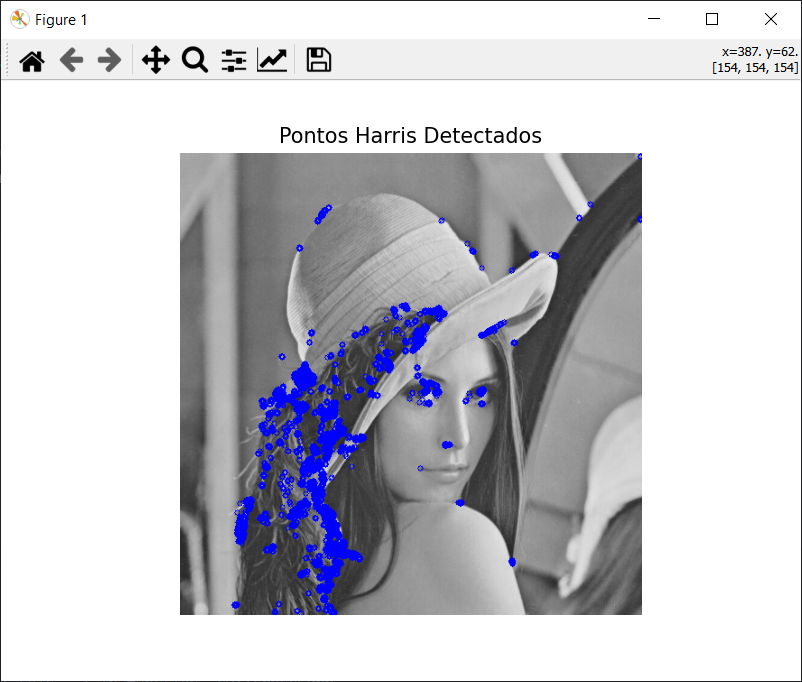

## 2. Sendo a entrada de uma função os pontos detectados no passo anterior, implemente uma função para realizar o rastreamento destes pontos (detectá-los em uma segunda imagem). Você pode implementar o rastreamento por:
*  ## Template matching considerando uma janela em torno dos pontos
*  ## Fluxo óptico

## Você pode utilizar as funções da OpenCV, mas a sua solução irá contar menos pontos.

### Template Matching:

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def rastrear_template_matching(pontos, imagem1_path, imagem2_path, janela_tamanho=21, limite_correlacao=0.5, escalas=3, metodo='TM_CCOEFF_NORMED', max_correspondencias=200, sobreposicao=0.8):
    # Carregar as imagens
    imagem1 = cv2.imread(imagem1_path, cv2.IMREAD_GRAYSCALE)
    imagem2 = cv2.imread(imagem2_path, cv2.IMREAD_GRAYSCALE)

    if imagem1 is None or imagem2 is None:
        print("Erro ao carregar as imagens.")
        return None

    # Cores para desenhar as correspondências
    cor_pontos = (0, 0, 255)  # Vermelho para pontos detectados

    # Criar uma cópia da segunda imagem para desenhar os pontos
    imagem_resultado = cv2.cvtColor(imagem2, cv2.COLOR_GRAY2BGR)

    # Para armazenar os pontos detectados
    pontos_detectados = []

    # Vamos usar diferentes métodos de Template Matching
    metodos = [cv2.TM_CCOEFF_NORMED, cv2.TM_SQDIFF_NORMED, cv2.TM_CCOEFF]

    # Para cada ponto, fazer o Template Matching
    for ponto in pontos:
        x, y = ponto
        # Definir uma janela em torno do ponto
        x1, y1 = max(0, x - janela_tamanho // 2), max(0, y - janela_tamanho // 2)
        x2, y2 = min(imagem1.shape[1], x + janela_tamanho // 2), min(imagem1.shape[0], y + janela_tamanho // 2)
        janela = imagem1[y1:y2, x1:x2]

        # Fazer Template Matching em várias escalas
        for escala in range(1, escalas + 1):
            # Reduzir ou aumentar a imagem conforme a escala
            escala_imagem2 = cv2.resize(imagem2, None, fx=1/(2**escala), fy=1/(2**escala))

            # Tentando diferentes métodos de Template Matching
            for metodo_atual in metodos:
                resultado = cv2.matchTemplate(escala_imagem2, janela, metodo_atual)

                # Encontrar a posição com a maior correlação
                _, max_val, _, max_loc = cv2.minMaxLoc(resultado)

                # Se a correlação for maior que o limite, considere a correspondência
                if max_val > limite_correlacao:
                    # Ajuste a localização de volta para a escala original
                    max_loc = (int(max_loc[0] * (2**escala)), int(max_loc[1] * (2**escala)))

                    pontos_detectados.append((max_loc, max_val))

    # Ordenar os pontos detectados pela correlação e manter os mais confiáveis
    pontos_detectados = sorted(pontos_detectados, key=lambda p: -p[1])

    # Limitar o número de correspondências, mas de forma redundante
    pontos_filtrados = [ponto for ponto, _ in pontos_detectados[:max_correspondencias]]

    # Desenhar os pontos rastreados na imagem de resultado
    for ponto in pontos_filtrados:
        cv2.circle(imagem_resultado, ponto, 5, cor_pontos, 2)

    # Exibir o resultado
    plt.imshow(imagem_resultado)
    plt.title('Template Matching - Rastreamento de Pontos')
    plt.axis('off')
    plt.show()

# Exemplo de uso
pontos = [(100, 150), (200, 250), (300, 350)]  # Lista de pontos Harris detectados na primeira imagem
rastrear_template_matching(pontos, '000000.png', '000001.png')


O código aqui desenvolvido implementa uma técnica de Template Matching para rastrear a localização de pontos de interesse entre duas imagens, com base em uma lista de pontos fornecida pela primeira imagem. A ideia principal é usar uma "janela" da primeira imagem e procurar por regiões semelhantes na segunda imagem, em várias escalas.

A função _rastrear_template_matching_ recebe os seguintes parâmetros:

- pontos: Lista de pontos na primeira imagem (tipicamente detectados por um algoritmo como Harris) que serão rastreados na segunda imagem.
- imagem1_path e imagem2_path: Caminhos para as duas imagens que serão usadas na correspondência.
- janela_tamanho: O tamanho da janela (em pixels) em torno de cada ponto de interesse para realizar a correspondência.
- limite_correlacao: Limite mínimo de correlação para considerar uma correspondência válida.
- escalas: Número de escalas para realizar a correspondência, o que permite procurar correspondências em diferentes resoluções.
- metodo: O método de template matching a ser usado (exemplo: TM_CCOEFF_NORMED).
max_correspondencias: Número máximo de correspondências a serem exibidas.
- sobreposicao: Fator de sobreposição (não é usado diretamente no código, mas geralmente se refere à distância mínima entre as correspondências para evitar duplicatas).

Este código ratreia em várias escalas. A correspondência é validada com base em um limite de correlação, e as correspondências mais confiáveis são desenhadas na imagem final, que é exibida ao final da execução do código.

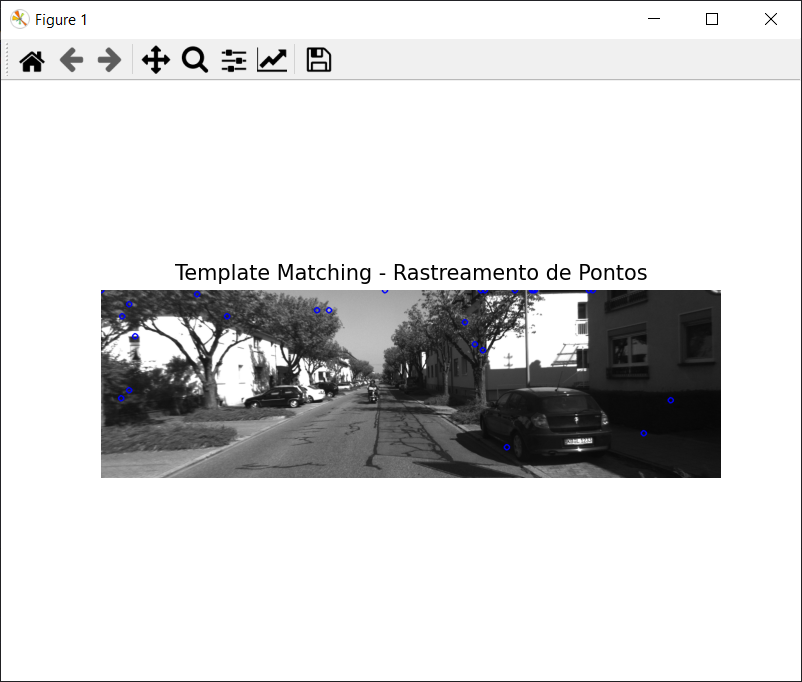

### Fluxo Ótico

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def rastrear_fluxo_optico(pontos, imagem1_path, imagem2_path, lk_params=None, max_correspondencias=200, win_size=(31, 31), max_level=4, criterios_terminacao=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 50, 0.01)):
    # Carregar as imagens
    imagem1 = cv2.imread(imagem1_path, cv2.IMREAD_GRAYSCALE)
    imagem2 = cv2.imread(imagem2_path, cv2.IMREAD_GRAYSCALE)

    if imagem1 is None or imagem2 is None:
        print("Erro ao carregar as imagens.")
        return None

    # Detectar mais pontos de interesse usando Shi-Tomasi ou Harris Corner (opcional)
    pontos_adicionais = cv2.goodFeaturesToTrack(imagem1, mask=None, **{
        'maxCorners': max_correspondencias,
        'qualityLevel': 0.01,
        'minDistance': 10,
        'blockSize': 3
    })

    # Combinar os pontos detectados manualmente com os detectados automaticamente
    if pontos_adicionais is not None:
        pontos_adicionais = pontos_adicionais.reshape(-1, 2)
        pontos = np.vstack([pontos, pontos_adicionais])  # Adicionar mais pontos detectados

    pontos = np.array(pontos, dtype=np.float32).reshape(-1, 1, 2)

    # Parâmetros do método de fluxo óptico
    if lk_params is None:
        lk_params = dict(winSize=win_size, maxLevel=max_level, criteria=criterios_terminacao)

    # Calcular o fluxo óptico (pontos de imagem1 para imagem2)
    pontos_rastreados, status, erro = cv2.calcOpticalFlowPyrLK(imagem1, imagem2, pontos, None, **lk_params)

    # Criar uma cópia da imagem 2 para desenhar os pontos
    imagem_resultado = cv2.cvtColor(imagem2, cv2.COLOR_GRAY2BGR)

    # Para cada ponto, desenhar o ponto rastreado
    for i, (novo_ponto, antigo_ponto) in enumerate(zip(pontos_rastreados, pontos)):
        a, b = antigo_ponto.ravel()
        c, d = novo_ponto.ravel()
        cv2.circle(imagem_resultado, (int(c), int(d)), 5, (0, 0, 255), -1)  # Desenha o ponto rastreado

        # Desenhar uma linha entre o ponto original e o rastreado
        cv2.line(imagem_resultado, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)

    # Exibir o resultado
    plt.imshow(imagem_resultado)
    plt.title('Fluxo Óptico - Rastreamento de Pontos')
    plt.axis('off')
    plt.show()

# Exemplo de uso
pontos = [(100, 150), (200, 250)]  # Lista de pontos Harris detectados na primeira imagem
rastrear_fluxo_optico(pontos, '000000.png', '000001.png')


Este código realiza o rastreamento de pontos de interesse entre duas imagens usando a técnica de fluxo óptico.
O fluxo óptico é utilizado para estimar o movimento de objetos entre duas imagens consecutivas, ou seja, rastrear a posição de pontos de uma imagem para outra. O método utilizado aqui é o Lucas-Kanade Optical Flow (cv2.calcOpticalFlowPyrLK), que é uma das técnicas mais populares para esse tipo de tarefa.

A função recebe os seguintes parâmetros:
- pontos: Lista de pontos a serem rastreados de uma imagem para outra. Esses pontos podem ser fornecidos manualmente (por exemplo, detectados por Harris).
- imagem1_path e imagem2_path: Caminhos para as duas imagens a serem comparadas.
- lk_params: Parâmetros para o método de fluxo óptico, com valor padrão None (o que usa valores padrão internos).
- max_correspondencias: Número máximo de pontos a serem rastreados.
- win_size: Tamanho da janela usada pelo algoritmo Lucas-Kanade para o cálculo do fluxo óptico.
- max_level: O número máximo de níveis na pirâmide de imagens usada pelo método de fluxo óptico.
- criterios_terminacao: Critérios de término para o cálculo de fluxo, como número de iterações e precisão.

Este código pode detectar automaticamente pontos de interesse (caso não sejam fornecidos), calculando o movimento desses pontos entre as duas imagens e exibindo o resultado, mostrando os pontos rastreados e as linhas que indicam o movimento ao final da execução do código.

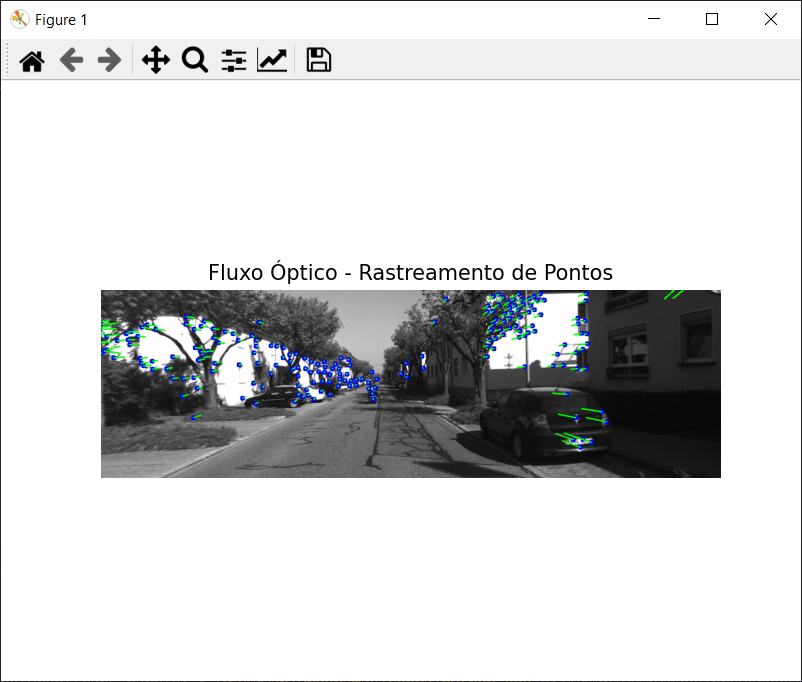

Percebe-se que obtive um melhor resultado na implementação que fiz com o Fluxo Ótico, obtendo mais pontos, o que significa que o algoritmo detectou mais "semelhanças" entre as duas imagens que representam um movimento/algo em movimento.